<a href="https://colab.research.google.com/github/razim-manzoor/Airline-Passenger-Satisfaction-Prediction-ANN/blob/main/ANNPassengerSatisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [22]:
pd.set_option('display.max_columns', None)

# Load data
data = pd.read_csv('/content/airline_passenger_satisfaction.csv')

In [23]:
data.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,Satisfied


In [24]:
data['Satisfaction'].unique()

array(['Neutral or Dissatisfied', 'Satisfied'], dtype=object)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [26]:
# Data preprocessing
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(columns=['ID'], errors='ignore')

    # Handle missing values
    df['Arrival Delay'] = df['Arrival Delay'].fillna(df['Departure Delay'])

    # Convert target variable
    df['Satisfaction'] = df['Satisfaction'].map({'Satisfied': 1, 'Neutral or Dissatisfied': 0})

    return df

In [27]:
# Apply preprocessing
data = preprocess_data(data)

In [28]:
# Check for class imbalance in the 'Satisfaction' column
satisfaction_counts = data['Satisfaction'].value_counts()
print(satisfaction_counts)

# Calculate the percentage of each class
satisfaction_percentages = satisfaction_counts / len(data) * 100
satisfaction_percentages

Satisfaction
0    73452
1    56428
Name: count, dtype: int64


,count
Satisfaction,
0,56.553742
1,43.446258


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Gender                                  129880 non-null  object 
 1   Age                                     129880 non-null  int64  
 2   Customer Type                           129880 non-null  object 
 3   Type of Travel                          129880 non-null  object 
 4   Class                                   129880 non-null  object 
 5   Flight Distance                         129880 non-null  int64  
 6   Departure Delay                         129880 non-null  int64  
 7   Arrival Delay                           129880 non-null  float64
 8   Departure and Arrival Time Convenience  129880 non-null  int64  
 9   Ease of Online Booking                  129880 non-null  int64  
 10  Check-in Service                        1298

In [29]:
data.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,0
1,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,1
2,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,1
3,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,1
4,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,1


In [30]:
# Split features and target
X = data.drop('Satisfaction', axis=1)
y = data['Satisfaction']

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Define preprocessing pipeline
numeric_features = [
    'Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay',
    'Departure and Arrival Time Convenience', 'Ease of Online Booking',
    'Check-in Service', 'Online Boarding', 'Gate Location', 'On-board Service',
    'Seat Comfort', 'Leg Room Service', 'Cleanliness', 'Food and Drink',
    'In-flight Service', 'In-flight Wifi Service', 'In-flight Entertainment',
    'Baggage Handling'
]
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

In [34]:
# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [54]:
# Save the preprocessing pipeline
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [36]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.8841087777815595, 1: 1.1508572947587612}

In [37]:
# Build ANN model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [40]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8647 - loss: 0.4326 - val_accuracy: 0.9329 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 2/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9277 - loss: 0.2278 - val_accuracy: 0.9435 - val_loss: 0.1735 - learning_rate: 0.0010
Epoch 3/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9390 - loss: 0.1863 - val_accuracy: 0.9498 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 4/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9468 - loss: 0.1597 - val_accuracy: 0.9499 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 5/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9516 - loss: 0.1469 - val_accuracy: 0.9520 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 6/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9510 - loss: 0.1447 - val_accuracy: 0.9569 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 7/100
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9534 - loss: 0.

In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,861 (163.52 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,908 (109.02 KB)

In [42]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9653 - loss: 0.0928

Test Accuracy: 0.9649
Test Loss: 0.0923


In [55]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [47]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14690
           1       0.97      0.95      0.96     11286

    accuracy                           0.96     25976
   macro avg       0.97      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



In [48]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9955


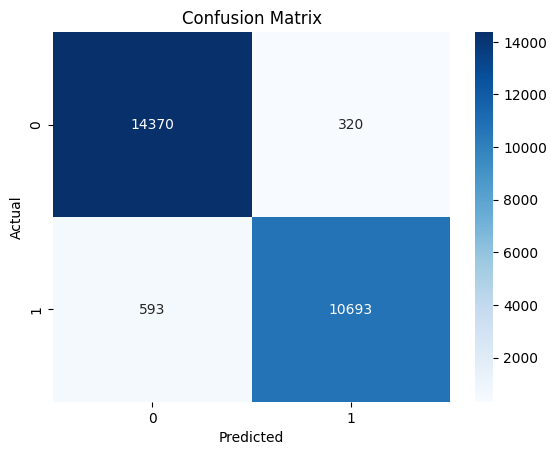

In [49]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

Precision-Recall AUC: 0.9946


In [52]:
# Save the trained model
model.save('passenger_satisfaction_model.h5')
print("Model and preprocessing pipeline saved successfully!")

Model and preprocessing pipeline saved successfully!
